In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pjain9696","key":"027412762bbf4355d6eb498caa185ea3"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:27<00:00, 39.4MB/s]
100% 2.29G/2.29G [00:27<00:00, 88.5MB/s]


In [5]:
import os
os.getcwd()

'/content'

In [6]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [7]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 47kB/s 


In [8]:
!nvidia-smi

Sat Apr  3 09:51:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import glob
import cv2
import random

import tensorflow as tf

#print versions
print('tensorflow version',tf.__version__)

tensorflow version 2.4.1


utility functions:

In [36]:
def print_results(y_test, y_pred):
    print('Accuracy   : {:.5f}'.format(accuracy_score(y_pred , y_test))) 
    print('AUC        : {:.5f}'.format(roc_auc_score(y_test , y_pred)))
    print('Precision  : {:.5f}'.format(precision_score(y_test , y_pred)))
    print('Recall     : {:.5f}'.format(recall_score(y_test , y_pred)))
    print('F1         : {:.5f}'.format(f1_score(y_test , y_pred)))
    print('Confusion Matrix : \n', confusion_matrix(y_test, y_pred))

## 1. Load Data

In [10]:
train_path = '/content/chest_xray/train'
val_path = '/content/chest_xray/val'
test_path = '/content/chest_xray/test'

In [11]:
train_files_original = glob.glob(train_path+'/*/*')
val_files_original = glob.glob(val_path+'/*/*')
test_files = glob.glob(test_path+'/*/*')

print('number of train samples across classes:', len(train_files_original))
print('number of val samples across classes:', len(val_files_original))
print('number of test samples across classes:', len(test_files))

number of train samples across classes: 5216
number of val samples across classes: 16
number of test samples across classes: 624


## 2. Process Inputs

As you can see, there are only 16 samples in validation set (~0.3%), we would prefer to have a greater proportion of samples included in validation set. Let's create a 80:20 split between train and test

In [174]:
files = np.unique(train_files_original + val_files_original)
train_files, val_files = train_test_split(files, test_size=0.3, shuffle=True)

print('number of train samples:', len(train_files))
print('number of val samples:', len(val_files))

number of train samples: 3662
number of val samples: 1570


Check distribution of classes in train set

In [175]:
count_normal = len([x for x in train_files if 'NORMAL' in x])
count_pneumonia = len([x for x in train_files if 'PNEUMONIA' in x])

print('Count of NORMAL images in train:', count_normal)
print('Count of PNEUMONIA images in train:', count_pneumonia)

Count of NORMAL images in train: 936
Count of PNEUMONIA images in train: 2726


There appears to be imbalance in number of normal and pneumonia cases, we'll handle it through class_weight during model building

In [176]:
IMG_SIZE = 180
def process_inputs(files_list):
  data = []
  for file in files_list:
    try:
      # figure out label
      parts = file.split('/')
      assert parts[-2] in ['NORMAL', 'PNEUMONIA']
      label = 1 if parts[-2] == "PNEUMONIA" else 0

      # figure out image pixel array
      img_arr = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
      resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
    except Exception as e:
      raise Exception(e)
    data.append([resized_arr, label])
  return np.array(data)

In [177]:
train = process_inputs(train_files)
val = process_inputs(val_files)
test = process_inputs(test_files)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [178]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

In [179]:
# see one sample
x_train[0]

array([[17, 19, 19, ..., 15, 17, 14],
       [16, 17, 17, ..., 10, 12, 14],
       [15, 15, 13, ...,  1,  8, 10],
       ...,
       [27, 27, 28, ..., 34, 34, 34],
       [27, 28, 27, ..., 34, 34, 34],
       [27, 28, 27, ..., 34, 35, 34]], dtype=uint8)

The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down.

In [180]:
x_train = np.array(x_train) / 255.
x_val = np.array(x_val) / 255.
x_test = np.array(x_test) / 255.

In [181]:
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

## 3. Visualize

label =  1


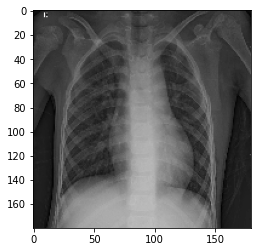

In [182]:
plt.imshow(x_train[0].reshape(180,180), cmap='gray')
print('label = ', y_train[0])

In [184]:
print(len(x_train))
print(len(x_val))
print(len(x_test))

3662
1570
624


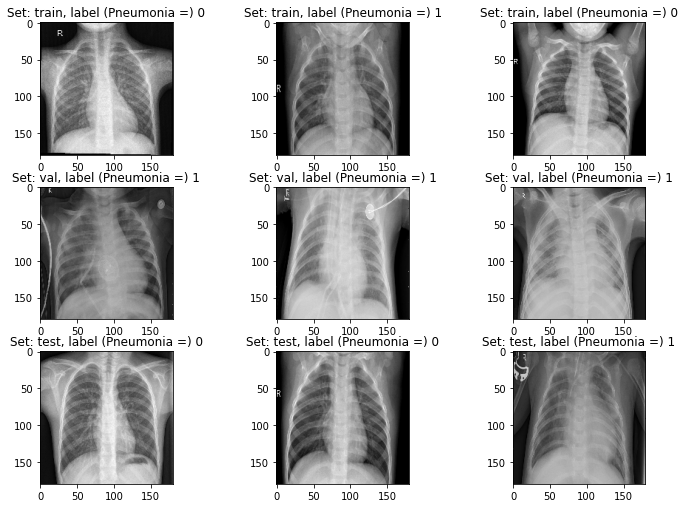

In [185]:
fig, ax = plt.subplots(3, 3, figsize=(10, 7))
ax = ax.ravel()
plt.tight_layout()

for i in range(3):
  random_index = random.randint(0, min(len(x_train), len(x_val), len(x_test)))
  ax[i].imshow(x_train[random_index].reshape(180,180), cmap='gray')
  ax[i].set_title('Set: train, label (Pneumonia =) {}'.format(y_train[random_index]))

  ax[i+3].imshow(x_val[random_index].reshape(180,180), cmap='gray')
  ax[i+3].set_title('Set: val, label (Pneumonia =) {}'.format(y_val[random_index]))

  ax[i+6].imshow(x_test[random_index].reshape(180,180), cmap='gray')
  ax[i+6].set_title('Set: test, label (Pneumonia =) {}'.format(y_test[random_index]))

## 4. Build and Train CNN

To make the code easier to understand, let's define functions to add Conv layers and Dense layers

In [186]:
def conv_block(filters):
  block = tf.keras.Sequential([
    tf.keras.layers.SeparableConv2D(filters, (3,3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(filters, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),    
  ])
  return block

In [187]:
def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
    tf.keras.layers.Dense(units, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
  ])
  return block

In [189]:
def build_model():
  model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    
    conv_block(128),
    tf.keras.layers.Dropout(0.2),

    conv_block(256),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    dense_block(256, 0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

during loading data we noticed that there is a class imbalance between normal vs pneumonia samples - pneumonia samples are approximately 3x normal samples. Let's utilize 'class_weight' to counter class imbalance

In [190]:
weight_for_normal = len(x_train) / (2 * count_normal)
weight_for_pneumonia = len(x_train) / (2 * count_pneumonia)

class_weight = {0:weight_for_normal, 1:weight_for_pneumonia}

print('weight for class 0 (normal): {:.3f}'.format(weight_for_normal))
print('weight for class 1 (pneumonia): {:.3f}'.format(weight_for_pneumonia))

weight for class 0 (normal): 1.956
weight for class 1 (pneumonia): 0.672


since normal samples are less, there will be a higher penalty (proportional to weight) to mis-classify normal sample

In [191]:
# compile model

model = build_model()

metrics = [
  'accuracy', 
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [197]:
epochs = 30
batch_size = 100

In [198]:
len(x_train)

3662

In [199]:
history = model.fit(
    x=x_train, 
    y=y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(x_val,y_val), 
    class_weight=class_weight
)

Epoch 1/30
37/37 [==============================] - 13s 354ms/step - loss: 0.0942 - accuracy: 0.9650 - precision: 0.9894 - recall: 0.9633 - val_loss: 1.4004 - val_accuracy: 0.7369 - val_precision: 0.7369 - val_recall: 1.0000
Epoch 2/30
37/37 [==============================] - 13s 344ms/step - loss: 0.0698 - accuracy: 0.9732 - precision: 0.9918 - recall: 0.9721 - val_loss: 1.4464 - val_accuracy: 0.7369 - val_precision: 0.7369 - val_recall: 1.0000
Epoch 3/30
37/37 [==============================] - 13s 347ms/step - loss: 0.0637 - accuracy: 0.9779 - precision: 0.9933 - recall: 0.9769 - val_loss: 1.5045 - val_accuracy: 0.7369 - val_precision: 0.7369 - val_recall: 1.0000
Epoch 4/30
37/37 [==============================] - 13s 341ms/step - loss: 0.0663 - accuracy: 0.9760 - precision: 0.9925 - recall: 0.9751 - val_loss: 1.5022 - val_accuracy: 0.7369 - val_precision: 0.7369 - val_recall: 1.0000
Epoch 5/30
37/37 [==============================] - 13s 347ms/step - loss: 0.0584 - accuracy: 0.9765

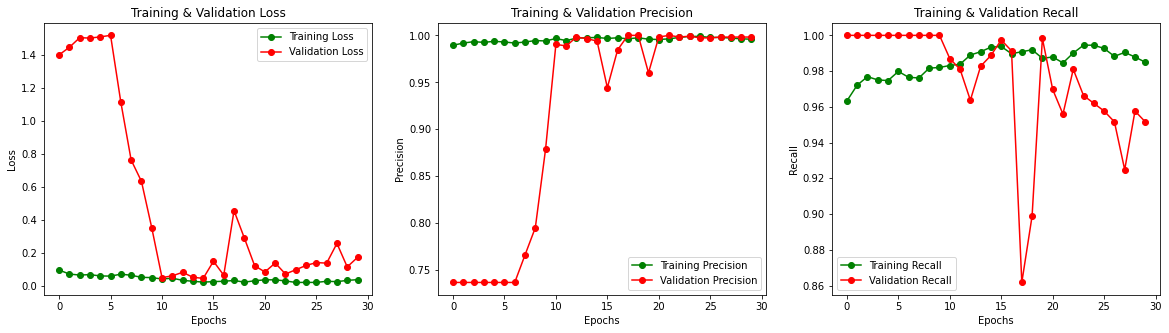

In [208]:
epochs_array = [i for i in range(epochs)]
fig, ax = plt.subplots(1,3)
train_precision = history.history['precision']
train_recall = history.history['recall']
train_loss = history.history['loss']

val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_loss = history.history['val_loss']
fig.set_size_inches(20,5)

ax[0].plot(epochs_array, train_loss, 'g-o', label='Training Loss')
ax[0].plot(epochs_array, val_loss, 'r-o', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

ax[1].plot(epochs_array, train_precision, 'go-', label='Training Precision')
ax[1].plot(epochs_array, val_precision, 'ro-', label='Validation Precision')
ax[1].set_title('Training & Validation Precision')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Precision')
ax[1].grid(True)

ax[2].plot(epochs_array, train_recall, 'go-', label='Training Recall')
ax[2].plot(epochs_array, val_recall, 'ro-', label='Validation Recall')
ax[2].set_title('Training & Validation Recall')
ax[2].legend()
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Recall')
ax[2].grid(True)

plt.show()

In [209]:
predictions = model.predict(x=x_test)
y_pred = np.round(predictions).reshape(1,-1)[0]

In [210]:
print_results(y_test, y_pred)

Accuracy   : 0.81731
AUC        : 0.76838
Precision  : 0.78992
Recall     : 0.96410
F1         : 0.86836
Confusion Matrix : 
 [[134 100]
 [ 14 376]]


In [211]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

### 4.1. Fine Tune Model

In [312]:
# compile model

model = build_model()

metrics = [
  'accuracy', 
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=metrics)

In [321]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('xray_model.h5', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_precision', patience=15, verbose=1, restore_best_weights=True)

In [314]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_precision', factor=0.3, patience=5, verbose=1, mode='max', min_lr=0.000001)

In [315]:
epochs = 50
batch_size = 64

In [322]:
history_ft = model.fit(
    x=x_train, 
    y=y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(x_val,y_val), 
    class_weight=class_weight,
    callbacks = [checkpoint_cb, early_stopping_cb, lr_reduce]
)

Epoch 1/50
58/58 [==============================] - 13s 215ms/step - loss: 0.1554 - accuracy: 0.9421 - precision: 0.9850 - recall: 0.9365 - val_loss: 0.1133 - val_accuracy: 0.9694 - val_precision: 0.9885 - val_recall: 0.9697
Epoch 2/50
58/58 [==============================] - 13s 219ms/step - loss: 0.1680 - accuracy: 0.9427 - precision: 0.9816 - recall: 0.9406 - val_loss: 0.1039 - val_accuracy: 0.9720 - val_precision: 0.9852 - val_recall: 0.9767
Epoch 3/50
58/58 [==============================] - 13s 224ms/step - loss: 0.1600 - accuracy: 0.9424 - precision: 0.9827 - recall: 0.9391 - val_loss: 0.1022 - val_accuracy: 0.9713 - val_precision: 0.9843 - val_recall: 0.9767
Epoch 4/50
58/58 [==============================] - 13s 220ms/step - loss: 0.1647 - accuracy: 0.9429 - precision: 0.9827 - recall: 0.9398 - val_loss: 0.1014 - val_accuracy: 0.9707 - val_precision: 0.9835 - val_recall: 0.9767
Epoch 5/50
58/58 [==============================] - 13s 219ms/step - loss: 0.1552 - accuracy: 0.9465

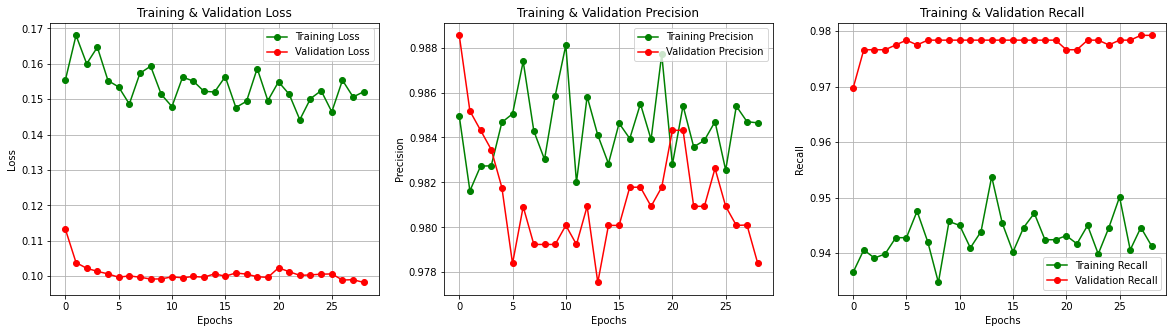

In [323]:
epochs_array = [i for i in range(len(history_ft.history['accuracy']))]
fig, ax = plt.subplots(1,3)
train_precision = history_ft.history['precision']
train_recall = history_ft.history['recall']
train_loss = history_ft.history['loss']

val_precision = history_ft.history['val_precision']
val_recall = history_ft.history['val_recall']
val_loss = history_ft.history['val_loss']
fig.set_size_inches(20,5)

ax[0].plot(epochs_array, train_loss, 'g-o', label='Training Loss')
ax[0].plot(epochs_array, val_loss, 'r-o', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

ax[1].plot(epochs_array, train_precision, 'go-', label='Training Precision')
ax[1].plot(epochs_array, val_precision, 'ro-', label='Validation Precision')
ax[1].set_title('Training & Validation Precision')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Precision')
ax[1].grid(True)

ax[2].plot(epochs_array, train_recall, 'go-', label='Training Recall')
ax[2].plot(epochs_array, val_recall, 'ro-', label='Validation Recall')
ax[2].set_title('Training & Validation Recall')
ax[2].legend()
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Recall')
ax[2].grid(True)
plt.show()

In [329]:
predictions = model.predict(x=x_test)
y_pred = np.round(predictions).reshape(1,-1)[0]

In [330]:
print_results(y_test, y_pred)

Accuracy   : 0.74679
AUC        : 0.66496
Precision  : 0.71402
Recall     : 0.99231
F1         : 0.83047
Confusion Matrix : 
 [[ 79 155]
 [  3 387]]


As seen above, our fine tuned model is able to correctly identify all pneumonia positive cases (100% recall). However, precision is ~70% which means that our model would generate a false alarm for 30% healthy patients. This is not an ideal situation. If you have thoughts about how to improve precision while keeping high recall, please let me know in comments.

### 4.2. Look at incorrectly classified cases


In [285]:
incorrect = np.nonzero(y_test != y_pred)[0]

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(10, 7))
ax = ax.ravel()
plt.tight_layout()

for i in range(3):
  random_index = random.randint(0, min(len(x_train), len(x_val), len(x_test)))
  ax[i].imshow(x_train[random_index].reshape(180,180), cmap='gray')
  ax[i].set_title('Set: train, label (Pneumonia =) {}'.format(y_train[random_index]))

  ax[i+3].imshow(x_val[random_index].reshape(180,180), cmap='gray')
  ax[i+3].set_title('Set: val, label (Pneumonia =) {}'.format(y_val[random_index]))

  ax[i+6].imshow(x_test[random_index].reshape(180,180), cmap='gray')
  ax[i+6].set_title('Set: test, label (Pneumonia =) {}'.format(y_test[random_index]))

In [291]:
incorrect[:6]

array([ 2,  4,  6,  8, 10, 12])

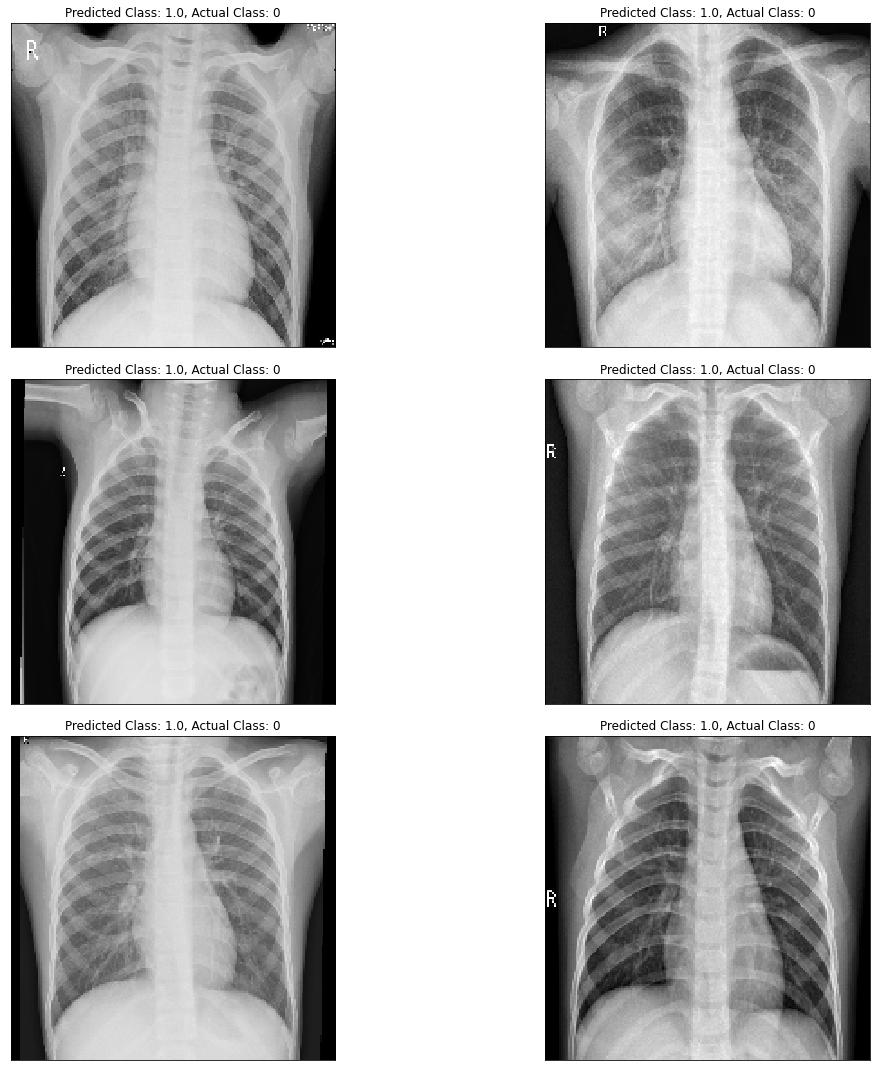

In [300]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))
ax = ax.ravel()
plt.subplots_adjust(wspace=0.25, hspace=0.75)
plt.tight_layout()
i = 0
for c in incorrect[:6]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(x_test[c].reshape(IMG_SIZE,IMG_SIZE), cmap='gray', interpolation='none')
    ax[i].set_title('Predicted Class: {}, Actual Class: {}'.format(y_pred[c], y_test[c]))
    i += 1 